# Import Libraries

In [0]:
from pyspark.sql.types import *
from pyspark.sql import functions as F

# Data Extraction and Cleaning

In [0]:
sales_df = spark.read.table('workspace.default.online_retail')
sales_df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows


Transform InvoiceDate from string type to date type.

In [0]:
# Change the data type of InvoiceDate from 'M/d/yyyy H:mm' to 'yyyy-MM-dd HH:mm:ss' in InvoiceDate_NewFormat
sales2_df = sales_df.select('*', F.from_unixtime(F.unix_timestamp(F.col('InvoiceDate'), 'M/d/yyyy H:mm')).alias('InvoiceDate_NewFormat'))
 
# Change the data type of InvoiceDate_NewFormat from string to date in InvoiceDate_DateType
sales3_df = sales2_df.select('*', F.col('InvoiceDate_NewFormat').cast('date').alias('InvoiceDate_DateType')) 

sales3_df.select('InvoiceDate','InvoiceDate_NewFormat','InvoiceDate_DateType').show(5, True)

+--------------+---------------------+--------------------+
|   InvoiceDate|InvoiceDate_NewFormat|InvoiceDate_DateType|
+--------------+---------------------+--------------------+
|12/1/2009 7:45|  2009-12-01 07:45:00|          2009-12-01|
|12/1/2009 7:45|  2009-12-01 07:45:00|          2009-12-01|
|12/1/2009 7:45|  2009-12-01 07:45:00|          2009-12-01|
|12/1/2009 7:45|  2009-12-01 07:45:00|          2009-12-01|
|12/1/2009 7:45|  2009-12-01 07:45:00|          2009-12-01|
+--------------+---------------------+--------------------+
only showing top 5 rows


In [0]:
# Create a TempView to use in the SQL query
sales3_df.createOrReplaceTempView('sales')

customers_df = spark.sql("""
SELECT CustomerID, Country
, MAX(InvoiceDate_DateType) AS last_purchase
, COUNT(DISTINCT InvoiceNo) AS frequency
, COUNT(DISTINCT StockCode) AS diversity
, SUM(Quantity * UnitPrice) AS monetary
FROM sales
GROUP BY CustomerID, Country
""")

customers_df.show(5)

+----------+--------------+-------------+---------+---------+------------------+
|CustomerID|       Country|last_purchase|frequency|diversity|          monetary|
+----------+--------------+-------------+---------+---------+------------------+
|     16607|United Kingdom|   2011-11-22|       29|      212|           5375.18|
|     16175|United Kingdom|   2011-09-06|        7|       59|1836.4399999999996|
|     18084|United Kingdom|   2011-11-23|        5|        8| 193.7300000000002|
|     13854|United Kingdom|   2011-12-01|       45|       61|          12158.21|
|     15696|United Kingdom|   2011-11-06|       21|      163|           3757.47|
+----------+--------------+-------------+---------+---------+------------------+
only showing top 5 rows


In [0]:
# Find the max date for recency calculation
customers_df.select(F.max(F.col('last_purchase'))).show()

+------------------+
|max(last_purchase)|
+------------------+
|        2011-12-09|
+------------------+



We can see the last date is 2011-12-09, so we will use 2011-12-10 as the current date for the recency calculation

In [0]:
customers_df = customers_df.withColumn('current_date', F.lit('2011-12-10'))
customers_df.show(5)

+----------+--------------+-------------+---------+---------+------------------+------------+
|CustomerID|       Country|last_purchase|frequency|diversity|          monetary|current_date|
+----------+--------------+-------------+---------+---------+------------------+------------+
|     16607|United Kingdom|   2011-11-22|       29|      212|           5375.18|  2011-12-10|
|     16175|United Kingdom|   2011-09-06|        7|       59|1836.4399999999996|  2011-12-10|
|     18084|United Kingdom|   2011-11-23|        5|        8| 193.7300000000002|  2011-12-10|
|     13854|United Kingdom|   2011-12-01|       45|       61|          12158.21|  2011-12-10|
|     15696|United Kingdom|   2011-11-06|       21|      163|           3757.47|  2011-12-10|
+----------+--------------+-------------+---------+---------+------------------+------------+
only showing top 5 rows


In [0]:
customers_with_recency = customers_df.withColumn('recency', F.datediff(F.col('current_date'), F.col('last_purchase')))
customers_with_recency.show(5)

+----------+--------------+-------------+---------+---------+------------------+------------+-------+
|CustomerID|       Country|last_purchase|frequency|diversity|          monetary|current_date|recency|
+----------+--------------+-------------+---------+---------+------------------+------------+-------+
|     16607|United Kingdom|   2011-11-22|       29|      212|           5375.18|  2011-12-10|     18|
|     16175|United Kingdom|   2011-09-06|        7|       59|1836.4399999999996|  2011-12-10|     95|
|     18084|United Kingdom|   2011-11-23|        5|        8| 193.7300000000002|  2011-12-10|     17|
|     13854|United Kingdom|   2011-12-01|       45|       61|          12158.21|  2011-12-10|      9|
|     15696|United Kingdom|   2011-11-06|       21|      163|           3757.47|  2011-12-10|     34|
+----------+--------------+-------------+---------+---------+------------------+------------+-------+
only showing top 5 rows


Keep only the interesting variables 
* CustomerID: Customer Identification 
* Country: Country were the store is located 
* Diversity: Number of diferent items bought by the same customer
* Frequency: Number of times the same customer bought
* Recency: Number of days past by the last purchase of the customer
* Monetary: Money spend by the customer

In [0]:
customers_with_key_features = customers_with_recency.select('CustomerID', 'Country', 'diversity' , 'frequency', 'recency', 'monetary')
customers_with_key_features.show(5)

+----------+--------------+---------+---------+-------+------------------+
|CustomerID|       Country|diversity|frequency|recency|          monetary|
+----------+--------------+---------+---------+-------+------------------+
|     16607|United Kingdom|      212|       29|     18|           5375.18|
|     16175|United Kingdom|       59|        7|     95|1836.4399999999996|
|     18084|United Kingdom|        8|        5|     17| 193.7300000000002|
|     13854|United Kingdom|       61|       45|      9|          12158.21|
|     15696|United Kingdom|      163|       21|     34|           3757.47|
+----------+--------------+---------+---------+-------+------------------+
only showing top 5 rows


## Deleting outliers

In [0]:
# Deleting customers with monetary lower than 0 
customers_with_positive_monetary = customers_with_key_features.filter(F.col('monetary') > 0)

# Print the customers deleted
print(customers_with_key_features.count() - customers_with_positive_monetary.count())

# Min and max monetary
customers_with_positive_monetary.select(F.min('monetary')).show()

100
+--------------------+
|       min(monetary)|
+--------------------+
|1.776356839400250...|
+--------------------+



In [0]:
quantiles = customers_with_positive_monetary.approxQuantile('monetary', [0.25, 0.5, 0.75], 0)
q1 = quantiles[0]
q2 = quantiles[1]
q3 = quantiles[2]

# Calculate the interquartile range
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(lower_bound)
print(upper_bound)
customers_final = customers_with_positive_monetary.filter((F.col('monetary') >= lower_bound) & (F.col('monetary') <= upper_bound))

print(customers_with_positive_monetary.count())
print(customers_final.count())
customers_final.select(F.min('monetary')).show()

-2492.2649999999994
5061.775
5870
5244
+--------------------+
|       min(monetary)|
+--------------------+
|1.776356839400250...|
+--------------------+



# Model preparation

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pyspark.ml.functions as mF
import matplotlib.pyplot as plt

In [0]:
customers_final.printSchema()

root
 |-- CustomerID: long (nullable = true)
 |-- Country: string (nullable = true)
 |-- diversity: long (nullable = false)
 |-- frequency: long (nullable = false)
 |-- recency: integer (nullable = true)
 |-- monetary: double (nullable = true)



## One Hot Encoding

We need to encode the categorical variables, but first we need to do a StringIndex

In [0]:
indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex") # To index the categorical variable
indexerModel = indexer.fit(customers_final) # To apply the indexer
customer_indexed = indexerModel.transform(customers_final) # To transform the categorical variable
customer_indexed.select('Country', 'CountryIndex').distinct().show(5)

+--------------+------------+
|       Country|CountryIndex|
+--------------+------------+
|United Kingdom|         0.0|
|   Netherlands|         5.0|
|      Portugal|         6.0|
|   Switzerland|         8.0|
|           USA|        17.0|
+--------------+------------+
only showing top 5 rows


Encoding the data

In [0]:
encoder = OneHotEncoder(inputCol="CountryIndex", outputCol="CountryVector") # To one-hot encode the indexed variable
model = encoder.fit(customer_indexed) # To apply the encoder
customer_encoded = model.transform(customer_indexed) # To transform the indexed variable
customer_encoded.select('Country', 'CountryIndex', 'CountryVector').distinct().show(5)

+--------------+------------+---------------+
|       Country|CountryIndex|  CountryVector|
+--------------+------------+---------------+
|United Kingdom|         0.0| (38,[0],[1.0])|
|   Netherlands|         5.0| (38,[5],[1.0])|
|      Portugal|         6.0| (38,[6],[1.0])|
|   Switzerland|         8.0| (38,[8],[1.0])|
|           USA|        17.0|(38,[17],[1.0])|
+--------------+------------+---------------+
only showing top 5 rows


## Vector Assembler

In [0]:
assembler = VectorAssembler(inputCols=['frequency', 'recency', 'diversity', 'monetary', 'CountryVector'], outputCol="features")
customer_assembled = assembler.transform(customer_encoded)
customer_assembled.select('features').distinct().show(5, False)

+--------------------------------------------------------+
|features                                                |
+--------------------------------------------------------+
|(42,[0,1,2,3,4],[7.0,95.0,59.0,1836.4399999999996,1.0]) |
|(42,[0,1,2,3,4],[5.0,17.0,8.0,193.7300000000002,1.0])   |
|(42,[0,1,2,3,4],[21.0,34.0,163.0,3757.47,1.0])          |
|(42,[0,1,2,3,4],[16.0,86.0,155.0,4461.42,1.0])          |
|(42,[0,1,2,3,4],[1.0,419.0,16.0,280.88000000000005,1.0])|
+--------------------------------------------------------+
only showing top 5 rows


## Elbow method

In [0]:
wssse_values = []
ks = []
for k in range(2, 10):
    kmeans = KMeans(featuresCol="features", k=k, seed=27)
    model = kmeans.fit(customer_assembled)
    wssse = model.summary.trainingCost
    wssse_values.append(wssse)
    ks.append(k)

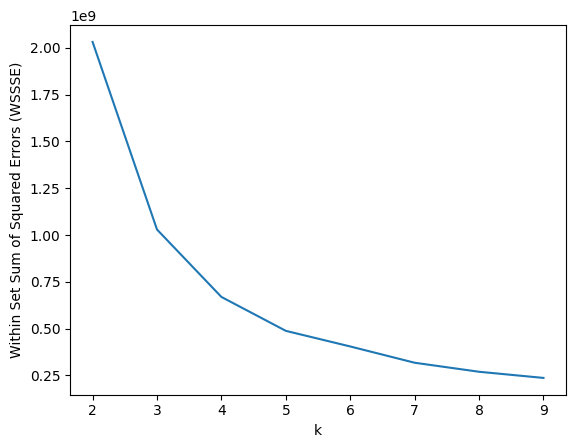

In [0]:
plt.plot(ks, wssse_values)
plt.xlabel("k")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.show()

In this graph we saw that the best k value (number of clusters is 4)

In [0]:
customer_assembled.show(5)

+----------+--------------+---------+---------+-------+------------------+------------+--------------+--------------------+
|CustomerID|       Country|diversity|frequency|recency|          monetary|CountryIndex| CountryVector|            features|
+----------+--------------+---------+---------+-------+------------------+------------+--------------+--------------------+
|     16175|United Kingdom|       59|        7|     95|1836.4399999999996|         0.0|(38,[0],[1.0])|(42,[0,1,2,3,4],[...|
|     18084|United Kingdom|        8|        5|     17| 193.7300000000002|         0.0|(38,[0],[1.0])|(42,[0,1,2,3,4],[...|
|     15696|United Kingdom|      163|       21|     34|           3757.47|         0.0|(38,[0],[1.0])|(42,[0,1,2,3,4],[...|
|     15122|United Kingdom|      155|       16|     86|           4461.42|         0.0|(38,[0],[1.0])|(42,[0,1,2,3,4],[...|
|     15772|United Kingdom|       16|        1|    419|280.88000000000005|         0.0|(38,[0],[1.0])|(42,[0,1,2,3,4],[...|
+-------

In [0]:
customer_assembled.repartition(4) # To repartition the data
customer_assembled.sortWithinPartitions("CustomerID") # To control the repartition and have reproducible results

kmeans_best = KMeans(featuresCol="features", k=4, seed=27)
model = kmeans_best.fit(customer_assembled.select("features"))
customers_clusters = model.transform(customer_assembled)
customers_clusters.select('CustomerID','prediction').show(5)

+----------+----------+
|CustomerID|prediction|
+----------+----------+
|     16175|         3|
|     18084|         0|
|     15696|         1|
|     15122|         1|
|     15772|         0|
+----------+----------+
only showing top 5 rows


## Evaluate the model

In [0]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(customers_clusters.select('features','prediction'))
print(silhouette)

0.6998940260698346


# Segmentation Analysis

In [0]:
customers_clusters.show(5)

+----------+--------------+---------+---------+-------+------------------+------------+--------------+--------------------+----------+
|CustomerID|       Country|diversity|frequency|recency|          monetary|CountryIndex| CountryVector|            features|prediction|
+----------+--------------+---------+---------+-------+------------------+------------+--------------+--------------------+----------+
|     16175|United Kingdom|       59|        7|     95|1836.4399999999996|         0.0|(38,[0],[1.0])|(42,[0,1,2,3,4],[...|         3|
|     18084|United Kingdom|        8|        5|     17| 193.7300000000002|         0.0|(38,[0],[1.0])|(42,[0,1,2,3,4],[...|         0|
|     15696|United Kingdom|      163|       21|     34|           3757.47|         0.0|(38,[0],[1.0])|(42,[0,1,2,3,4],[...|         1|
|     15122|United Kingdom|      155|       16|     86|           4461.42|         0.0|(38,[0],[1.0])|(42,[0,1,2,3,4],[...|         1|
|     15772|United Kingdom|       16|        1|    419|

In [0]:
# Keep the important variables 
customers_final = customers_clusters.select('CustomerID','diversity','frequency','recency','monetary','prediction')

# Import seaborn for plot
import seaborn as sns

## Recency vs Monetary

<Axes: xlabel='recency', ylabel='monetary'>

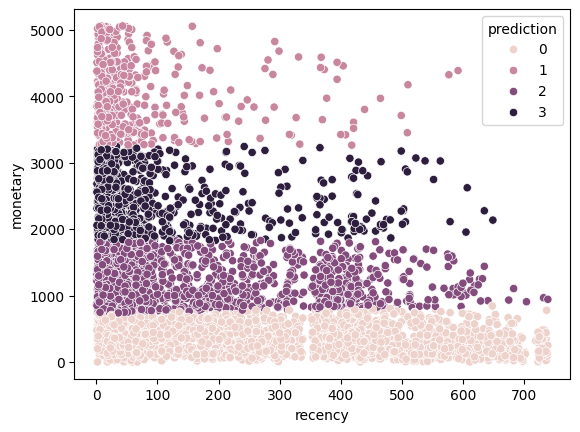

In [0]:
sns.scatterplot(x='recency', y='monetary', hue='prediction', data=customers_final.toPandas())

In this figure we see that segment 1 spend more, and have low recency, we can make targeting marketing to impulse repurchase on that segment

## Frequency vs Monetary

<Axes: xlabel='frequency', ylabel='monetary'>

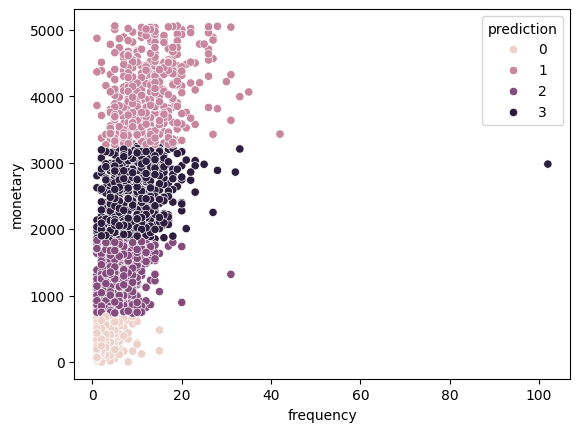

In [0]:
sns.scatterplot(x='frequency', y='monetary', hue='prediction', data=customers_final.toPandas())

## Diversity vs Monetary

<Axes: xlabel='diversity', ylabel='monetary'>

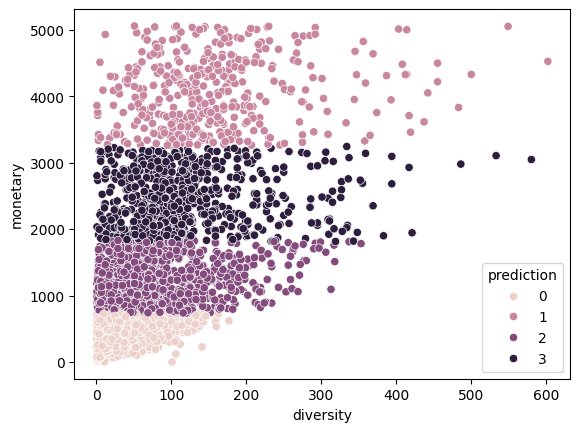

In [0]:
sns.scatterplot(x='diversity', y='monetary', hue='prediction', data=customers_final.toPandas())

## Cluster profiling

In [0]:
customers_final.filter("prediction = 0").describe(['diversity', 'frequency', 'recency', 'monetary']).show()

+-------+------------------+------------------+------------------+--------------------+
|summary|         diversity|         frequency|           recency|            monetary|
+-------+------------------+------------------+------------------+--------------------+
|  count|              2705|              2705|              2705|                2705|
|   mean|26.472088724584104| 2.022550831792976| 299.4184842883549|  343.12018151571186|
| stddev|24.634563912594892|1.4326115619038293|223.56403735891112|  196.27759095556712|
|    min|                 1|                 1|                 1|1.776356839400250...|
|    max|               177|                15|               739|               842.4|
+-------+------------------+------------------+------------------+--------------------+



In [0]:
customers_final.filter("prediction = 1").describe(['diversity', 'frequency', 'recency', 'monetary']).show()

+-------+------------------+-----------------+------------------+------------------+
|summary|         diversity|        frequency|           recency|          monetary|
+-------+------------------+-----------------+------------------+------------------+
|  count|               409|              409|               409|               409|
|   mean|157.11491442542788|12.87286063569682| 73.55012224938875|4045.8334254278734|
| stddev| 95.55664574807214|6.213794890706102|106.83927389910946| 517.6839720511274|
|    min|                 1|                1|                 1|3263.1899999999996|
|    max|               602|               42|               592|5059.3200000000015|
+-------+------------------+-----------------+------------------+------------------+



In [0]:
customers_final.filter("prediction = 2").describe(['diversity', 'frequency', 'recency', 'monetary']).show()

+-------+------------------+-----------------+------------------+------------------+
|summary|         diversity|        frequency|           recency|          monetary|
+-------+------------------+-----------------+------------------+------------------+
|  count|              1423|             1423|              1423|              1423|
|   mean| 72.77723120168658|5.047786366830639|156.14827828531273|1191.8526732255789|
| stddev|53.872436075414946|2.835225296223999|165.20019758947572| 300.7555962810044|
|    min|                 1|                1|                 1| 733.3999999999997|
|    max|               353|               31|               739|           1829.04|
+-------+------------------+-----------------+------------------+------------------+



In [0]:
customers_final.filter("prediction = 3").describe(['diversity', 'frequency', 'recency', 'monetary']).show()

+-------+------------------+-----------------+------------------+------------------+
|summary|         diversity|        frequency|           recency|          monetary|
+-------+------------------+-----------------+------------------+------------------+
|  count|               707|              707|               707|               707|
|   mean|117.76803394625176|9.203677510608204|104.61951909476662|2439.2658330975983|
| stddev| 82.08528658763693|5.755483952016165|136.06145842347735| 413.9325846295021|
|    min|                 1|                1|                 1|1813.5699999999997|
|    max|               580|              102|               649|3243.9300000000007|
+-------+------------------+-----------------+------------------+------------------+



In [0]:
type(customers_final)

pyspark.sql.connect.dataframe.DataFrame

### Profile Summary

**Segment 1: "The Champions" (n=409)** 
* **The Data:** Lowest Recency (73 days), Highest Frequency (12.8), Highest Spend ($4,045).
* **Insight:** These are your most active and freshest customers. With the lowest recency and highest frequency, they are in a virtuous cycle of buying. They are the core engine of your revenue.
* **Action:** Implement a VIP Loyalty Program. Focus on retention and brand advocacy.

**Segment 3: "Active Loyalists" (n=707)**
* **The Data:** Low Recency (104 days), High Frequency (9.2), High Spend ($2,439).
* **Insight:** A very healthy segment. While they don't spend as much as Segment 1, they are still very recent (shopping roughly every 3.5 months). They are highly engaged and represent the best opportunity for upselling.
* **Action:** Personalized Recommendations. Use their purchase history to suggest higher-value items to move them toward Segment 1.

**Segment 2: "Fading/Occasional Shoppers" (n=1,423)**
* **The Data:** Moderate Recency (156 days), Moderate Frequency (5.0), Moderate Spend ($1,192).
* **Insight:** This group is at a crossroads. A mean recency of 156 days (~5 months) suggests they are starting to drift away. Because the standard deviation (165) is larger than the mean, this group is highly polarized: some are still active, but many have already crossed the 300-day mark.
* **Action:** Re-activation Campaigns. Targeted "limited time" offers are needed here to trigger a purchase before they lapse into Segment 0.

**Segment 0: "Lapsed/Inactive" (n=2,705)**
* **The Data:** Highest Recency (299 days), Lowest Frequency (2.0), Lowest Spend ($343).
* **Insight:** These customers are largely cold. With a mean recency of nearly 300 days and only 2 purchases on average, these are likely one-time shoppers or people who have switched to a competitor.
* **Action:** Win-Back or Sunset. Attempt one deep-discount "Win-back" campaign. If they don't respond, it is more cost-effective to stop marketing to them to save on campaign costs.